In [1]:
#Load libraries
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import adam
import torchvision
import pathlib
from torchvision import datasets, transforms
import matplotlib as plt
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score





In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
train_path = "C:\\Users\\Hp\\OneDrive\\Desktop\\data\\dataset\\seg_train\\seg_train"
test_path = "C:\\Users\\Hp\\OneDrive\\Desktop\\data\\dataset\\seg_test\\seg_test"

train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform=transforms),
    batch_size=32, shuffle=True)

test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform=transforms),
    batch_size=32, shuffle=False)

# Optional: get class names
root = pathlib.Path(train_path)
classes = sorted([j.name for j in root.iterdir()])
print("Classes:", classes)


Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [4]:
# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [5]:
train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform=transform),
    batch_size=32, shuffle=True)

test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform=transform),
    batch_size=32, shuffle=False)


In [6]:
class MyCustomModel(nn.Module):
    def __init__(self):
        super(MyCustomModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(128 * 18 * 18, 256)
        self.fc2 = nn.Linear(256, 6)  # 6 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 150 -> 75
        x = self.pool(F.relu(self.conv2(x)))  # 75 -> 37
        x = self.pool(F.relu(self.conv3(x)))  # 37 -> 18
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [7]:
model = MyCustomModel().to(device)

criterion = nn.CrossEntropyLoss()  # Because it's a multi-class classification problem
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [8]:
num_epochs = 21

for epoch in range(num_epochs):
    model.train()  # Set to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()            # Clear gradients
        outputs = model(images)          # Forward pass
        loss = criterion(outputs, labels)# Compute loss
        loss.backward()                  # Backward pass
        optimizer.step()                 # Update weights

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/21], Loss: 0.8862
Epoch [2/21], Loss: 0.5683
Epoch [3/21], Loss: 0.4431
Epoch [4/21], Loss: 0.3395
Epoch [5/21], Loss: 0.2408
Epoch [6/21], Loss: 0.1672
Epoch [7/21], Loss: 0.1308
Epoch [8/21], Loss: 0.0855
Epoch [9/21], Loss: 0.0762
Epoch [10/21], Loss: 0.0880
Epoch [11/21], Loss: 0.0738
Epoch [12/21], Loss: 0.0396
Epoch [13/21], Loss: 0.0531
Epoch [14/21], Loss: 0.0540
Epoch [15/21], Loss: 0.0570
Epoch [16/21], Loss: 0.0535
Epoch [17/21], Loss: 0.0413
Epoch [18/21], Loss: 0.0375
Epoch [19/21], Loss: 0.0432
Epoch [20/21], Loss: 0.0428
Epoch [21/21], Loss: 0.0440


In [11]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 81.93%


In [12]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


In [13]:

print("Overall Accuracy:", accuracy_score(all_labels, all_preds))
print("Precision (macro):", precision_score(all_labels, all_preds, average='macro'))
print("Recall (macro):", recall_score(all_labels, all_preds, average='macro'))
print("F1-score (macro):", f1_score(all_labels, all_preds, average='macro'))


Overall Accuracy: 0.8193333333333334
Precision (macro): 0.8237348832271222
Recall (macro): 0.8177787029641527
F1-score (macro): 0.8178195306034902


In [14]:
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))



Classification Report:

              precision    recall  f1-score   support

   buildings       0.85      0.65      0.74       437
      forest       0.95      0.96      0.95       474
     glacier       0.80      0.79      0.80       553
    mountain       0.79      0.78      0.78       525
         sea       0.79      0.83      0.81       510
      street       0.77      0.89      0.83       501

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



Classification Report:
              precision    recall  f1-score   support

   buildings       0.85      0.65      0.74       437
      forest       0.95      0.96      0.95       474
     glacier       0.80      0.79      0.80       553
    mountain       0.79      0.78      0.78       525
         sea       0.79      0.83      0.81       510
      street       0.77      0.89      0.83       501

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



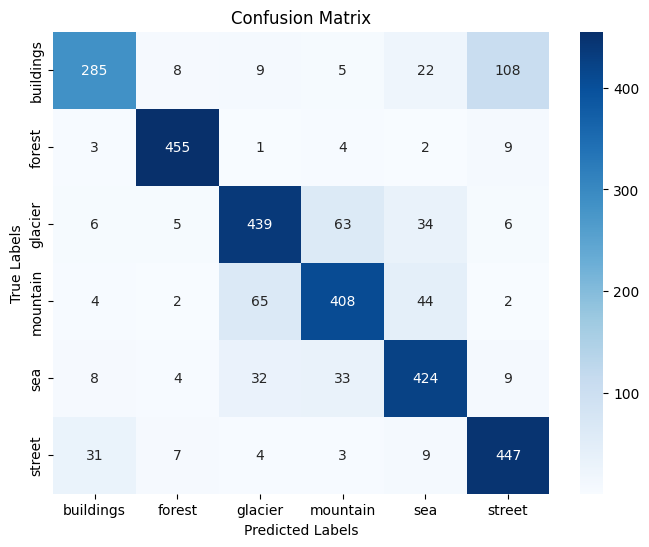

In [15]:

# Set the model to evaluation mode
model.eval()

all_preds = []
all_labels = []

# Iterate through the test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Collect all predictions and true labels
        all_preds.extend(predicted.cpu().numpy())  # Move to CPU for sklearn
        all_labels.extend(labels.cpu().numpy())   # Move to CPU for sklearn

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


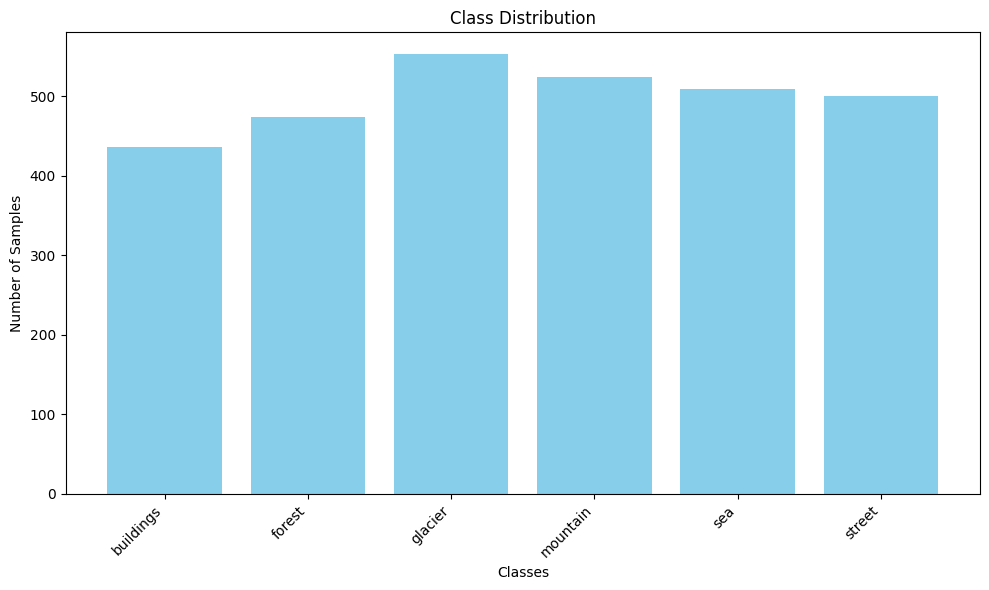

In [16]:


# Assuming you have already set up your train_loader and test_loader

# Function to plot the class distribution (counts) for the given DataLoader
def plot_class_distribution(data_loader, classes):
    class_counts = [0] * len(classes)  # Initialize a list of zeros for each class
    
    # Loop through the data loader and count the instances for each class
    for _, labels in data_loader:
        for label in labels:
            class_counts[label.item()] += 1  # Increment the count for the class label
    
    # Plotting the class distribution
    plt.figure(figsize=(10, 6))
    plt.bar(classes, class_counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    plt.xticks(rotation=45, ha='right')  # Rotate class names for better readability
    plt.tight_layout()  # Ensure everything fits without overlapping
    plt.show()

# Example usage: For your test_loader
plot_class_distribution(test_loader, classes)


In [17]:
torch.save(model.state_dict(), 'custom_cnn_model.pth')


In [18]:
model = MyCustomModel().to(device)
model.load_state_dict(torch.load('custom_cnn_model.pth'))
model.eval()  # For inference
print("model saved successfully")

model saved successfully


In [19]:
def predict_image(image_path, model, transform, classes, device):
    # Load and transform the image
    image = Image.open(image_path).convert('RGB')  # Ensure it's 3-channel RGB
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_class = torch.max(outputs, 1)

    predicted_class_name = classes[predicted_class.item()]

    # Unnormalize image for display
    img = image_tensor.squeeze(0).cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean  # reverse normalization
    img = img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
    img = np.clip(img, 0, 1)  # Clip to [0, 1] for display

    # Show the image
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

    return predicted_class_name


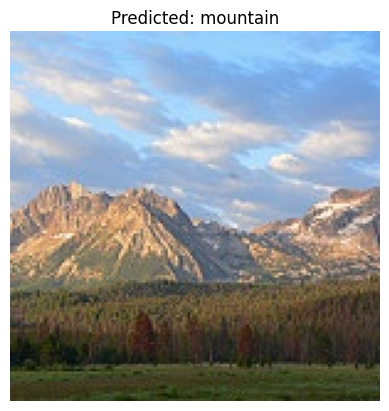

Predicted class: mountain


In [20]:

image_path = "c:\\Users\\Hp\\OneDrive\\Desktop\\data\\dataset\\seg_pred\\seg_pred\\28.jpg"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predicted_class = predict_image(image_path, model, transform, classes, device)
print(f"Predicted class: {predicted_class}")
